In [1]:
import sys
import os

# Add the 'src' directory to the Python path
src_dir = os.path.join(os.path.dirname(os.getcwd()), 'src')
sys.path.append(src_dir)

In [24]:
from NeuralNetwork import Neural_Network
from GD_class import GradientDescent
from cost_functions import grad_cost_logreg
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from tqdm import tqdm 

import seaborn as sns


# Loading and splitting the dataset

In [3]:
cancer = load_breast_cancer()
X_orig = jnp.array(cancer.data)
target = jnp.array(cancer.target)
target = target.reshape(len(target), 1)

# Splitting into training and test set
test_size = 0.2
X_train, X_test, target_train, target_test = train_test_split(X_orig, target, test_size=test_size)

# Scaling the data

In [4]:
# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training data
X_train_scaled = scaler.transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Setting up logistic regression
Using the neural network class we have developed, with no hidden layers and sigmoid as activation function for output layer.

# Tuning parameters

## Epochs and minibatches

In [16]:
n_hidden_layers = 0
n_hidden_nodes = 0

n_outputs = 1
n_features = X_train_scaled.shape[1] 

learning_rate = 0.01
lmbd = 0.0001

n_epochs_list = [50, 100, 150, 200]
n_minibatches_list = [8, 16, 32, 64]

accuracy = np.zeros((len(n_epochs_list), len(n_minibatches_list)))

kfold = KFold(n_splits=5, shuffle=True)

for k, n_epochs in enumerate(n_epochs_list):

    for i, n_minibatches in tqdm(enumerate(n_minibatches_list)):

        accuracy_crossval = []

        for train_index, val_index in kfold.split(X_train_scaled):
            
            # Splitting the data into training and validation set for cross-validation
            X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
            target_train_cv, target_val_cv = target_train[train_index], target_train[val_index]

            ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                  grad_cost_function=grad_cost_logreg,
                                  learning_rate=learning_rate, 
                                  lmbd=lmbd, 
                                  activation_function_output="sigmoid",
                                  optimizer=None,
                                  classification_problem=True)

            ffnn.train(X_train_cv, target_train_cv, num_iter=n_epochs, n_minibatches=n_minibatches)
            pred_val = ffnn.predict(X_val_cv)

            accuracy_crossval.append(accuracy_score(target_val_cv, pred_val))

        accuracy[k][i] = np.mean(accuracy_crossval)

4it [00:34,  8.62s/it]
4it [01:11, 17.95s/it]
4it [01:51, 27.95s/it]
4it [02:22, 35.55s/it]


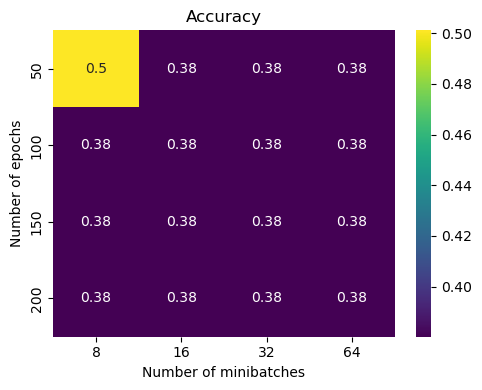

In [17]:
fig, ax = plt.subplots(figsize = (5, 4))
heatmap = sns.heatmap(accuracy, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(n_minibatches_list)
heatmap.set_yticklabels(n_epochs_list)
ax.set_title("Accuracy")
ax.set_ylabel("Number of epochs")
ax.set_xlabel("Number of minibatches")
plt.tight_layout()
plt.savefig(r"Figures\Task_e\Cancer_tune_epochs_and_minibatches_accuracy_logistic.png")
plt.show()


## Lambda and learning rate

In [9]:
n_hidden_layers = 0
n_hidden_nodes = 0

n_outputs = 1
n_features = X_train_scaled.shape[1] 

learning_rates = np.logspace(-4, 0, 5)
lmbd_vals = np.logspace(-5, -2, 4)
lmbd_vals = jnp.insert(lmbd_vals, 0, 0.0)

n_epochs = 50
n_minibatches = 8

accuracy = np.zeros((len(learning_rates), len(lmbd_vals)))

kfold = KFold(n_splits=5, shuffle=True)

for i, lr in tqdm(enumerate(learning_rates)):

    for j, lmbd in enumerate(lmbd_vals):

        accuracy_crossval = []

        for train_index, val_index in kfold.split(X_train_scaled):

            X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
            target_train_cv, target_val_cv = target_train[train_index], target_train[val_index]

            ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                  grad_cost_function=grad_cost_logreg,
                                  learning_rate=lr, 
                                  lmbd=lmbd, 
                                  activation_function_output="sigmoid",
                                  optimizer=None,
                                  classification_problem=True)

            ffnn.train(X_train_cv, target_train_cv, num_iter=n_epochs, n_minibatches=n_minibatches)
            pred_val = ffnn.predict(X_val_cv)

            accuracy_crossval.append(accuracy_score(target_val_cv, pred_val))

        accuracy[i][j] = np.mean(accuracy_crossval)

5it [01:02, 12.59s/it]


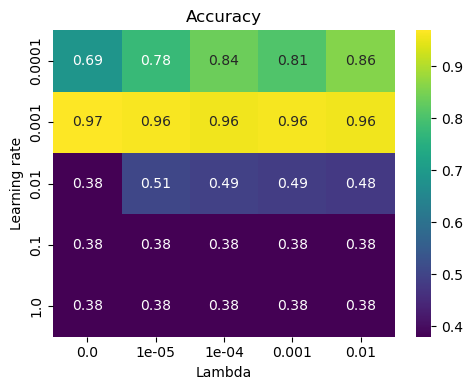

In [13]:
fig, ax = plt.subplots(figsize = (5, 4))
heatmap = sns.heatmap(accuracy, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(lmbd_vals)
heatmap.set_yticklabels(learning_rates)
ax.set_title("Accuracy")
ax.set_ylabel("Learning rate")
ax.set_xlabel("Lambda")
plt.tight_layout()
plt.savefig(r"Figures\Task_e\Accuracy_cancer_logreg.png")
plt.show()

## Final test of model

In [26]:
n_hidden_layers = 0
n_hidden_nodes = 0

n_outputs = 1
n_features = X_train_scaled.shape[1] 

learning_rate = 0.001
lmbd = 0.0

n_epochs = 50
n_minibatches = 8

# Training the network again with all the training data and the tuned parameters
ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                      grad_cost_function=grad_cost_logreg,
                      learning_rate=learning_rate, lmbd=lmbd, 
                      activation_function_output="sigmoid",
                      optimizer=None,
                      classification_problem=True)

ffnn.train(X_train_scaled, target_train, num_iter=n_epochs, n_minibatches=n_minibatches)
pred_test = ffnn.predict(X_test_scaled)

accuracy_test = accuracy_score(target_test, pred_test)
print(f"Accuracy for test data: {accuracy_test}")

Accuracy for test data: 0.9649122807017544


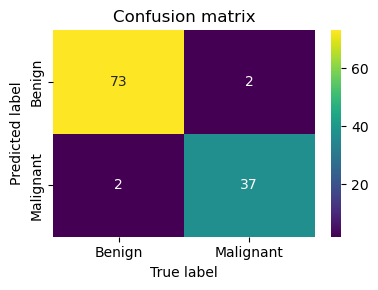

In [27]:
tn, fp, fn, tp = confusion_matrix(target_test, pred_test).ravel()
conf_matrix = [[tp, fp], [fn, tn]]

fig, ax = plt.subplots(figsize = (4, 3))
heatmap = sns.heatmap(conf_matrix, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(["Benign", "Malignant"])
heatmap.set_yticklabels(["Benign", "Malignant"])
ax.set_title("Confusion matrix")
ax.set_ylabel("Predicted label")
ax.set_xlabel("True label")
plt.tight_layout()
plt.savefig(r"Figures\Task_e\Cancer_confusion_matrix_logistic.png")
plt.show()